In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import re
import requests
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

In [2]:
products = {
    "crypto": [
        "BTC-USD",
        "ETH-USD",
        "SOL-USD",
        "XRP-USD",
        "ADA-USD",
        "DOGE-USD",
        "AVAX-USD",
        "LINK-USD",
        "DOT-USD",
        "MATIC-USD",
    ],
    "stock":  [],
}

etf_tickers = ["QQQ", "VUG", "VGT"]
common_holdings = []

def get_etf_holdings(url):
    with requests.Session() as req:
        global common_holdings
        
        req.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0"
        })
        
        for ticker in etf_tickers:
            r = req.get(url.format(ticker))
            print(f"Extracting: {r.url}")
            holdings = re.findall(r'etf\\\/(.*?)\\', r.text)
            top_holdings = holdings[:50]
            
            if len(common_holdings) == 0:
                common_holdings = top_holdings
            else:
                common_holdings = list(set(common_holdings).intersection(top_holdings))

get_etf_holdings("https://www.zacks.com/funds/etf/{}/holding")
print(common_holdings)
products["stock"] = common_holdings

Extracting: https://www.zacks.com/funds/etf/QQQ/holding
Extracting: https://www.zacks.com/funds/etf/VUG/holding
Extracting: https://www.zacks.com/funds/etf/VGT/holding
['ADBE', 'CDNS', 'TXN', 'INTU', 'KLAC', 'LRCX', 'AMAT', 'PANW', 'MSFT', 'AAPL', 'AMD', 'SNPS', 'NVDA']


In [3]:
def get_df_crypto_fear_greed_index():
    print("Retrieving historical crypto fear and greed index")
    fear_greed_index_response = requests.get("https://api.alternative.me/fng/?limit=" + str(24 * 365 * 5))
    df_fear_greed_index = pd.DataFrame(fear_greed_index_response.json()["data"])
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(int(x), unit="s", tz="UTC") for x in df_fear_greed_index.timestamp]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"value": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_etf_fear_greed_index():
    print("Retrieving historical ETF fear and greed index")
    import json

    with open("cnn_fear_greed_index_data.json") as f:
        cnn_fear_greed_index_data = json.load(f)

    df_fear_greed_index = pd.DataFrame(
        data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
    )
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id, product_type):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1d", period="3y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True).round(freq="D") for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_fear_greed_index = df_crypto_fear_greed_index if product_type == "crypto" else df_etf_fear_greed_index
    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]], how="inner")
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    def get_strategy_length(x):
        return x * 1

    for column in ["close", "fear_greed_index"]:
        for days in [7, 14, 30, 60, 90, 120]:
            periods = get_strategy_length(days)
            df_history[f"{column}_previous"] = df_history[column].shift(1)
            df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
            df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
            df_history[f"{column}_gradient_min_{days}"] = (
                df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
            )
            df_history[f"{column}_gradient_max_{days}"] = (
                df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
            )

    CustomStrategy = ta.Strategy(
        name="Momo and Volatility",
        ta=[
            {"kind": "sma", "length": get_strategy_length(10)},
            {"kind": "sma", "length": get_strategy_length(20)},
            {"kind": "sma", "length": get_strategy_length(50)},
            {"kind": "bbands", "length": get_strategy_length(20)},
            {"kind": "rsi", "length": get_strategy_length(14)},
            {
                "kind": "macd",
                "fast": get_strategy_length(8),
                "slow": get_strategy_length(21),
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(10),
                "prefix": "VOLUME",
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(20),
                "prefix": "VOLUME",
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(50),
                "prefix": "VOLUME",
            },
        ],
    )
    df_history.ta.strategy(CustomStrategy)

    return df_history


df_crypto_fear_greed_index = get_df_crypto_fear_greed_index()
df_etf_fear_greed_index = get_df_etf_fear_greed_index()

history_dfs = {}
product_ids = []

for product_type in products.keys():
    for product_id in products[product_type]:
        product_ids.append(product_id)
        history_dfs[product_id] = get_df_history(product_id, product_type=product_type)
        history_dfs[product_id]["product_id"] = product_id
        history_dfs[product_id]["product_type"] = product_type

df_final = pd.concat([history_dfs[product_id] for product_id in product_ids]).sort_index()

for product_id in product_ids:
    df_final_product = df_final.loc[df_final.product_id == product_id]
    # df_final = df_final.loc[(df_final.index >= df_final_product.index.min()) & (df_final.index <= df_final_product.index.max())]
    # df_final = df_final.loc[df_final.index.isin(df_final_product.index)]

df_final

Retrieving historical crypto fear and greed index
Retrieving historical ETF fear and greed index
Retrieving historical data for BTC-USD
Retrieving historical data for ETH-USD
Retrieving historical data for SOL-USD
Retrieving historical data for XRP-USD
Retrieving historical data for ADA-USD
Retrieving historical data for DOGE-USD
Retrieving historical data for AVAX-USD
Retrieving historical data for LINK-USD
Retrieving historical data for DOT-USD
Retrieving historical data for MATIC-USD
Retrieving historical data for ADBE
Retrieving historical data for CDNS
Retrieving historical data for TXN
Retrieving historical data for INTU
Retrieving historical data for KLAC
Retrieving historical data for LRCX
Retrieving historical data for AMAT
Retrieving historical data for PANW
Retrieving historical data for MSFT
Retrieving historical data for AAPL
Retrieving historical data for AMD
Retrieving historical data for SNPS
Retrieving historical data for NVDA


,open,high,low,close,volume,dividends,stock splits,fear_greed_index,close_previous,close_min_7,close_max_7,close_gradient_7,close_gradient_min_7,close_gradient_max_7,close_min_14,close_max_14,close_gradient_14,close_gradient_min_14,close_gradient_max_14,close_min_30,close_max_30,close_gradient_30,close_gradient_min_30,close_gradient_max_30,close_min_60,close_max_60,close_gradient_60,close_gradient_min_60,close_gradient_max_60,close_min_90,close_max_90,close_gradient_90,close_gradient_min_90,close_gradient_max_90,close_min_120,close_max_120,close_gradient_120,close_gradient_min_120,close_gradient_max_120,fear_greed_index_previous,fear_greed_index_min_7,fear_greed_index_max_7,fear_greed_index_gradient_7,fear_greed_index_gradient_min_7,fear_greed_index_gradient_max_7,fear_greed_index_min_14,fear_greed_index_max_14,fear_greed_index_gradient_14,fear_greed_index_gradient_min_14,fear_greed_index_gradient_max_14,fear_greed_index_min_30,fear_greed_index_max_30,fear_greed_index_gradient_30,fear_greed_index_gradient_min_30,fear_greed_index_gradient_max_30,fear_greed_index_min_60,fear_greed_index_max_60,fear_greed_index_gradient_60,fear_greed_index_gradient_min_60,fear_greed_index_gradient_max_60,fear_greed_index_min_90,fear_greed_index_max_90,fear_greed_index_gradient_90,fear_greed_index_gradient_min_90,fear_greed_index_gradient_max_90,fear_greed_index_min_120,fear_greed_index_max_120,fear_greed_index_gradient_120,fear_greed_index_gradient_min_120,fear_greed_index_gradient_max_120,SMA_10,SMA_20,SMA_50,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_10,VOLUME_SMA_20,VOLUME_SMA_50,product_id,product_type
2021-01-22 00:00:00+00:00,30817.625000,33811.851562,28953.373047,33005.761719,77207272511,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTC-USD,crypto
2021-01-22 00:00:00+00:00,0.268776,0.277843,0.244917,0.272799,4501765714,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XRP-USD,crypto
2021-01-22 00:00:00+00:00,1118.889038,1271.687622,1046.596558,1236.512207,43918338506,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ETH-USD,crypto
2021-01-22 00:00:00+00:00,0.310054,0.359159,0.283576,0.349577,4066222238,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADA-USD,crypto
2021-01-22 00:00:00+00:00,0.008165,0.008769,0.007654,0.008524,185490003,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOGE-USD,crypto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Total fee percentage: 0%
Start money: $10000
Min buy amount: $10
Max buy amount: $100
End money: $50220.19
Pct earned: 402.202%
Total orders: 9354
Avg pct earned per order: 0.043%
Total volume: $1247596.89
Total days: 1094.0
Avg 30 day volume: $34211.98


,product_id,side,amount,products,value,money,total_balance
timestamp,,,,,,,
2021-01-23 00:00:00+00:00,BTC-USD,buy,100.0,0.0031184082133999826,32067.642578125,9900.0,10000.0
2021-01-23 00:00:00+00:00,LINK-USD,buy,99.0,3.9981371378938535,24.761531829833984,9801.0,10000.0
2021-01-23 00:00:00+00:00,ADA-USD,buy,98.01,283.55845803555917,0.345643013715744,9702.99,10000.0
2021-01-23 00:00:00+00:00,DOGE-USD,buy,97.02,11309.010506877663,0.008578999899327755,9605.97,10000.0
2021-01-23 00:00:00+00:00,XRP-USD,buy,96.05,353.3575505391578,0.271820992231369,9509.92,10000.0
...,...,...,...,...,...,...,...
2024-01-19 00:00:00+00:00,ADA-USD,sell,289.6519959875188,575.67608183,0.503150999546051,32400.41433638368,33553.89364292128
2024-01-19 00:00:00+00:00,BTC-USD,sell,294.6728826921875,0.00708035,41618.40625,32695.087219075867,33553.89364292128
2024-01-19 00:00:00+00:00,XRP-USD,sell,288.93555680074365,530.88173895,0.5442559719085693,32984.02277587661,33553.89364292128


,product_id,side,total_orders
0,BTC-USD,buy,275
1,BTC-USD,sell,28
2,ETH-USD,buy,274
3,ETH-USD,sell,28
4,SOL-USD,buy,275
5,SOL-USD,sell,28
6,XRP-USD,buy,273
7,XRP-USD,sell,28
8,ADA-USD,buy,274
9,ADA-USD,sell,28


<Axes: xlabel='timestamp'>

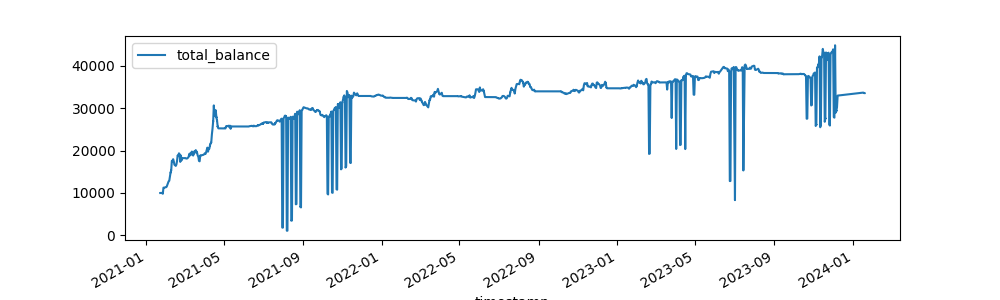

In [4]:
fee_pct = 0
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")

purchased_products = {}
total_products = len(product_ids)

for product_id in product_ids:
    purchased_products[product_id] = 0

money = 10000
start_money = money
print(f"Start money: ${start_money}")

min_buy_amount = 10
max_buy_amount = 100
print(f"Min buy amount: ${min_buy_amount}")
print(f"Max buy amount: ${max_buy_amount}")

total_orders = 0
total_volume = 0
orders = []


def get_total_balance():
    total_balance = money

    for product_product_id in product_ids:
        df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == product_product_id)]

        if len(df_final_product_period) > 0:
            total_balance += purchased_products[product_product_id] * df_final_product_period.close.values[-1] * p_keep

    return total_balance


def floor_value(x: float, precision: int):
    return np.true_divide(np.floor(x * 10**precision), 10**precision)


def buy_product(product_id):
    global money
    global orders
    global purchased_products
    global total_orders
    global total_volume

    product_data = df_final.loc[(df_final.index == index) & (df_final.product_id == product_id)].to_dict("records")

    if len(product_data) > 0:
        product_data = product_data[0]

        # buy_amount = floor_value(money / total_products / 10, 2)
        buy_amount = floor_value(money / len(products[product_data["product_type"]]) / 10, 2)
        buy_amount = buy_amount if buy_amount >= min_buy_amount else min_buy_amount
        buy_amount = buy_amount if buy_amount <= max_buy_amount else max_buy_amount

        if money >= buy_amount and buy_amount > 0:
            money -= buy_amount
            buy_products = buy_amount / product_data["close"] * p_keep
            purchased_products[product_id] += buy_products
            total_orders += 1
            total_volume += buy_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "buy",
                    "amount": buy_amount,
                    "products": buy_products,
                    "value": product_data["close"],
                    "money": money,
                    "total_balance": get_total_balance(),
                }
            )


def sell_product(product_id):
    global money
    global orders
    global purchased_products
    global total_orders
    global total_volume

    product_data = df_final.loc[(df_final.index == index) & (df_final.product_id == product_id)].to_dict("records")

    if len(product_data) > 0:
        product_data = product_data[0]

        sell_products = floor_value(purchased_products[product_id], 8)
        sell_amount = sell_products * product_data["close"] * p_keep

        if sell_amount > 0:
            purchased_products[product_id] -= sell_products
            total_orders += 1
            total_volume += sell_amount
            money += sell_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "sell",
                    "amount": sell_amount,
                    "products": sell_products,
                    "value": product_data["close"],
                    "money": money,
                    "total_balance": get_total_balance(),
                }
            )


for index, row in df_final.iterrows():
    if row.product_type == "crypto" and row.fear_greed_index >= 60:
        # for etf_product_id in products["stock"]:
        #     sell_product(etf_product_id)

        buy_product(row.product_id)
    elif row.product_type == "stock" and (
        row.RSI_14 >= row.fear_greed_index_max_14 or (row.RSI_14 >= 50 and row.fear_greed_index >= 50)
    ):
        # for crypto_product_id in products["crypto"]:
        #     sell_product(crypto_product_id)

        buy_product(row.product_id)
    else:
        sell_product(row.product_id)

money += sum(
    [
        (purchased_products[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
pct_earned = (money - start_money) / start_money * 100
print(f"Pct earned: {pct_earned:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total orders: {total_orders}")
print(f"Avg pct earned per order: {pct_earned / total_orders:.3f}%")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders.astype(str))

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append({"product_id": product_id, "side": side, "total_orders": len(df_orders_product_side)})

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)

df_orders[["total_balance"]].plot(figsize=(10, 3))

In [5]:
# display(df_orders.loc[df_orders.side == "buy"].describe())
# display(df_orders.loc[df_orders.side == "sell"].describe())

In [6]:
# df_final.loc[df_final.product_id == "VGT"][:100][["product_type", "close", "fear_greed_index", "fear_greed_index_max_14", "RSI_14"]]